#### Predict whether a person makes over 50K per year or not from classic adult dataset using XGBoost. 

In [1]:
import numpy as np
import pandas as pd
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)

test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None)

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
'native_country', 'wage_class']

train_set.columns = col_labels
test_set.columns = col_labels

In [2]:
train_set.shape

(32561, 15)

In [3]:
test_set.shape

(16281, 15)

In [4]:
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
test_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


#### Check for null values

In [6]:
train_set.isnull().sum(axis=0)

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

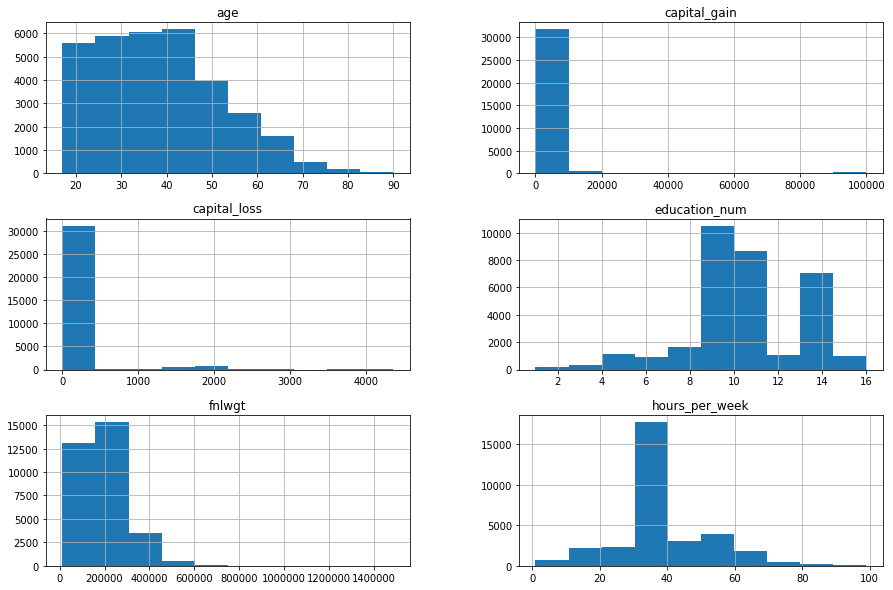

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
train_set.hist(figsize=(15,10))
plt.show()

#### Replace '?' in data

In [8]:
train_set.replace(' ?', np.nan).dropna().shape 

(30162, 15)

In [9]:
test_set.replace(' ?', np.nan).dropna().shape

(15060, 15)

In [10]:
train_nomissing = train_set.replace(' ?', np.nan).dropna()
test_nomissing = test_set.replace(' ?', np.nan).dropna()

In [11]:
test_nomissing['wage_class'] = test_nomissing.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})

In [12]:
test_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [13]:
train_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [14]:
combined_set = pd.concat([train_nomissing, test_nomissing], axis = 0) # Stacks them vertically

In [15]:
for feature in combined_set.columns: # Loop through all columns in the dataframe
    if combined_set[feature].dtype == 'object': # Only apply for columns with categorical strings
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes # Replace strings with an integer

In [16]:
final_train = combined_set[:train_nomissing.shape[0]] # Up to the last initial training set row
final_test = combined_set[train_nomissing.shape[0]:] # Past the last initial training set row

#### XGBOOST

In [20]:
y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

In [21]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

C:\Users\Patrick\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Patrick\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [22]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 
# Optimize for accuracy since that is the metric used in the Adult Data Set notation

In [23]:
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [24]:
optimized_GBM.grid_scores_

[mean: 0.86712, std: 0.00225, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.86659, std: 0.00339, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.86659, std: 0.00295, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.86214, std: 0.00197, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.86161, std: 0.00143, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.86208, std: 0.00236, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.85651, std: 0.00183, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.85575, std: 0.00246, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.85694, std: 0.00347, params: {'max_depth': 7, 'min_child_weight': 5}]

In [25]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [26]:
optimized_GBM.grid_scores_

[mean: 0.86622, std: 0.00198, params: {'learning_rate': 0.1, 'subsample': 0.7},
 mean: 0.86712, std: 0.00225, params: {'learning_rate': 0.1, 'subsample': 0.8},
 mean: 0.86758, std: 0.00299, params: {'learning_rate': 0.1, 'subsample': 0.9},
 mean: 0.86052, std: 0.00290, params: {'learning_rate': 0.01, 'subsample': 0.7},
 mean: 0.86029, std: 0.00297, params: {'learning_rate': 0.01, 'subsample': 0.8},
 mean: 0.86025, std: 0.00341, params: {'learning_rate': 0.01, 'subsample': 0.9}]

#### Early stopping CV

In [28]:
xgdmat = xgb.DMatrix(final_train, y_train) # Create our DMatrix to make XGBoost more efficient

In [29]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [30]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
489,0.115584,0.001395,0.129998,0.004691
490,0.115617,0.001414,0.129965,0.004479
491,0.115501,0.001397,0.129965,0.004494
492,0.115501,0.001483,0.129964,0.004581
493,0.115385,0.001528,0.129932,0.004657


In [31]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 432)

In [32]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)

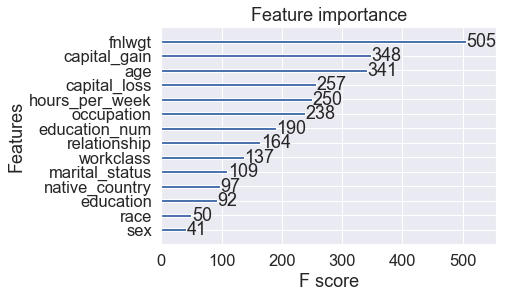

In [33]:
xgb.plot_importance(final_gb)